In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import joblib


In [ ]:
train_path = '/content/versions/marine-animals-dataset/versions/1/train'
test_path = '/content/versions/marine-animals-dataset/versions/1/test'


In [ ]:
# Image size for InceptionV3
img_size = (299, 299)

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for testing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data loaders
train_gen = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=32, class_mode='sparse', shuffle=True)

test_gen = test_datagen.flow_from_directory(
    test_path, target_size=img_size, batch_size=32, class_mode='sparse', shuffle=False)

print("Class indices:", train_gen.class_indices)


Found 1241 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Class indices: {'Dolphin': 0, 'Fish': 1, 'Lobster': 2, 'Octopus': 3, 'Sea Horse': 4}


In [ ]:
# Load InceptionV3 pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Create a feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Fine-tune last few layers by unfreezing them
for layer in feature_extractor.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
def extract_features(generator, feature_extractor):
    num_samples = generator.samples
    features = np.zeros((num_samples, np.prod(feature_extractor.output_shape[1:])))
    labels = np.zeros(num_samples)

    i = 0
    for inputs, targets in generator:
        batch_features = feature_extractor.predict(inputs, verbose=0)
        batch_size = inputs.shape[0]
        features[i:i + batch_size] = batch_features.reshape(batch_size, -1)
        labels[i:i + batch_size] = targets
        i += batch_size
        if i >= num_samples:
            break

    return features, labels

# Extract features
X_train, y_train = extract_features(train_gen, feature_extractor)
X_test, y_test = extract_features(test_gen, feature_extractor)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)


Training features shape: (1241, 131072)
Testing features shape: (100, 131072)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Number of components after PCA: {X_train_pca.shape[1]}")


Number of components after PCA: 1154


In [ ]:
 param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train_pca, y_train)

print("Best parameters:", grid.best_params_)
svm = grid.best_estimator_



Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.8s
[CV] END ....................C=0.1, gamma=scale

Classification Report:
              precision    recall  f1-score   support

     Dolphin       0.95      1.00      0.98        20
        Fish       1.00      0.55      0.71        20
     Lobster       1.00      0.90      0.95        20
     Octopus       0.73      0.95      0.83        20
   Sea Horse       0.79      0.95      0.86        20

    accuracy                           0.87       100
   macro avg       0.89      0.87      0.86       100
weighted avg       0.89      0.87      0.86       100



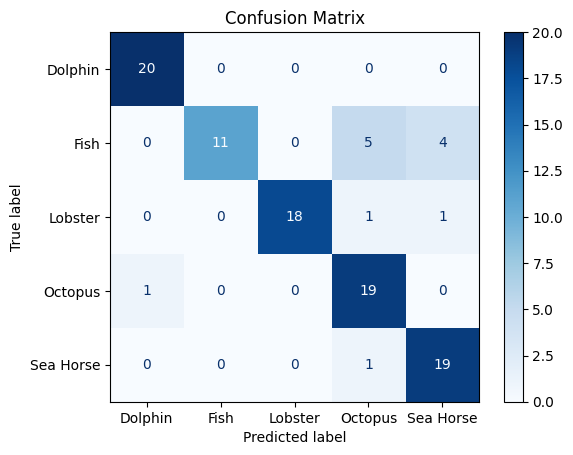

In [ ]:
y_pred = svm.predict(X_test_pca)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=train_gen.class_indices.keys()))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=train_gen.class_indices.keys(), cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
  joblib.dump(pca, "/content/pca_transform.pkl")
joblib.dump(svm, "/content/svm_model.pkl")
print("Models saved successfully!")


Models saved successfully!
